## Sunspot task

The Sunspot task consists in a next-step prediction (autoregressive, a particular case of transduction) on a [time-series](https://drive.google.com/file/d/1GK5fqzuAGoo466PIxhnwxtSP0r3uDFWa/view?usp=sharing) consisting in monthly averaged solar sunspots.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import itertools

from liquid_state_machine import LSM

In [2]:
dset = pd.read_csv('./solar_data.csv', header=None).to_numpy().squeeze()
dset

array([ 58. ,  62.6,  70. , ..., 132. , 105.2, 147. ])

In [3]:
dset.shape

(2899,)

Properly separate input and target data, then split the available data in
- training (first 2398 time steps), and
- test set (the subsequent 500 time steps).

In [4]:
#input_dset, target_dset = dset[:,:-1], dset[:,1:]
x_test = dset[-501:]
train = dset[:2398] 
tsize = int(len(train)*0.75)
x_val = train[tsize:]
x_train = train[:tsize]
y_train, y_val, y_test=x_train[1:], x_val[1:], x_test[1:]
x_train, x_val, x_test = x_train[:-1], x_val[:-1], x_test[:-1]

In [5]:
x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape

((1797,), (599,), (500,), (1797,), (599,), (500,))

Plot the time series of the sunspots

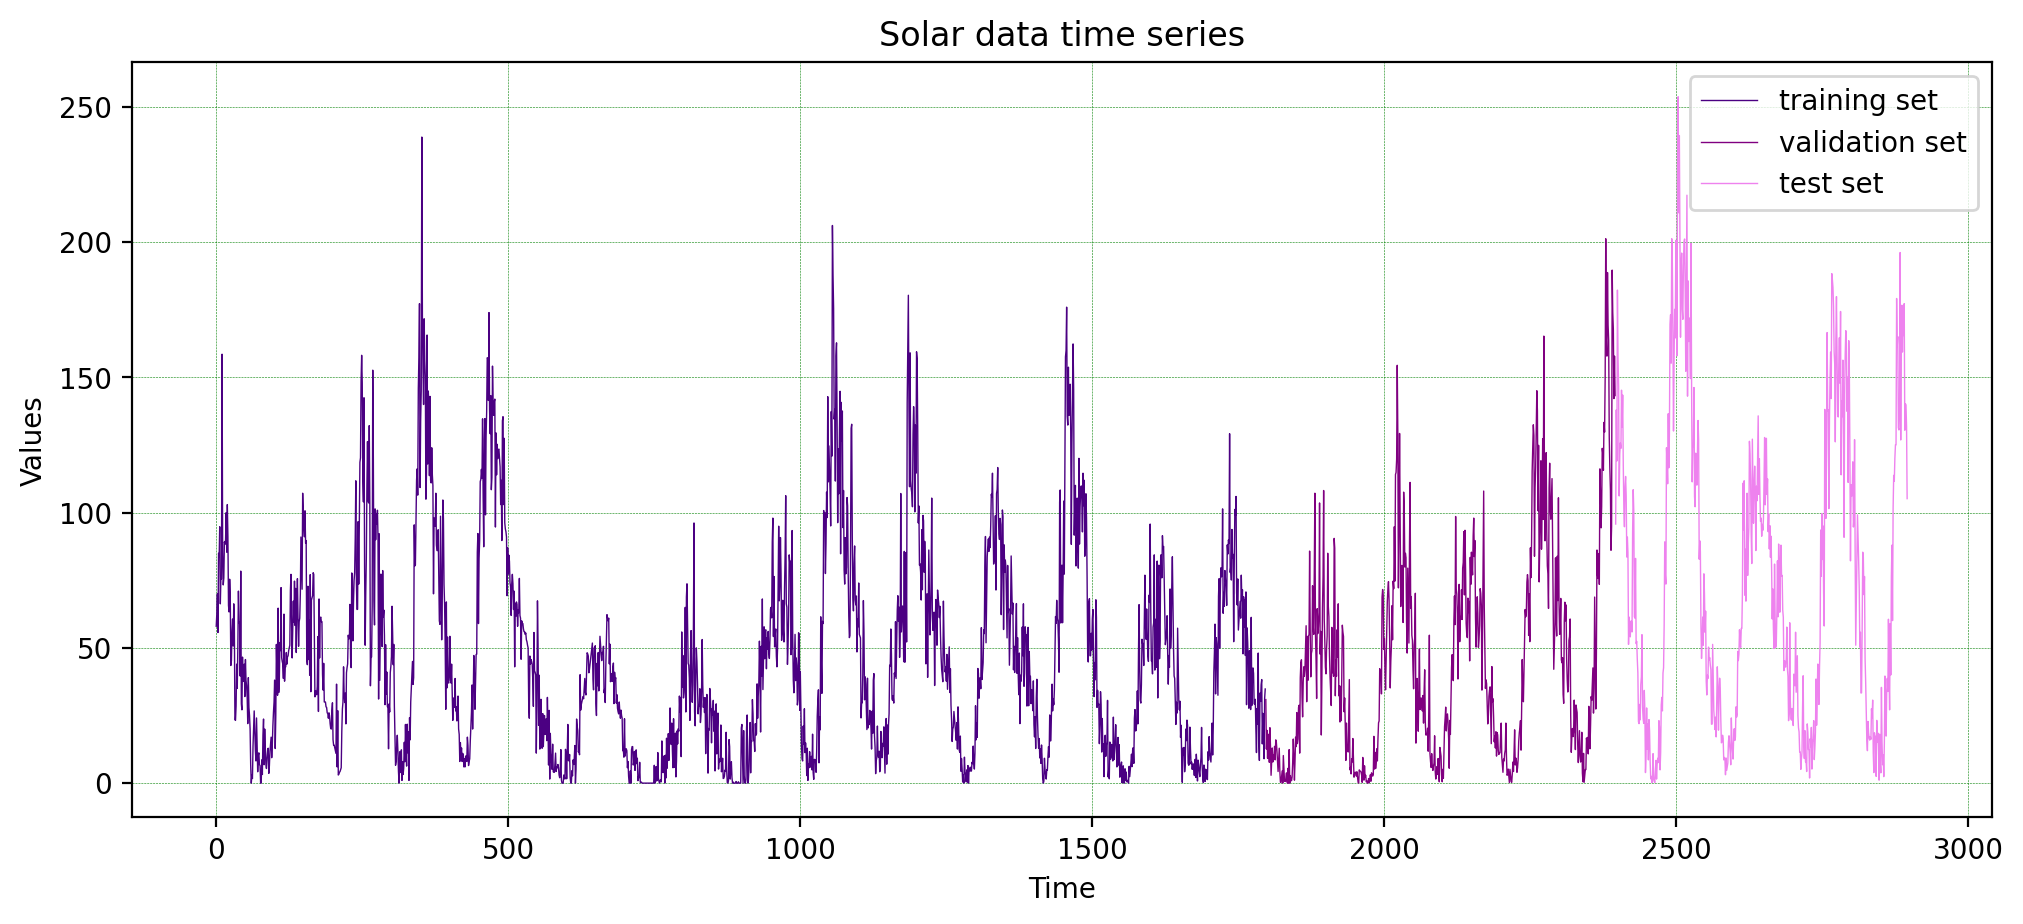

In [9]:
limit1=int(x_train.shape[0])
limit2=int(x_train.shape[0]+x_val.shape[0])
limit3=int(limit2+x_test.shape[0])

plt.figure(figsize=(12,5), dpi=200)
plt.plot(range(0,limit1), x_train, color="indigo", linewidth=0.5, label="training set") 
plt.plot(range(limit1,limit2), x_val, color="purple", linewidth=0.5, label="validation set") 
plt.plot(range(limit2,limit3), x_test, color="violet", linewidth=0.5, label="test set") 

plt.title("Solar data time series")
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()
plt.grid(color = 'green', linestyle = '--', linewidth = 0.2)
plt.savefig(str('plots/timeseries.jpeg'), edgecolor='black', dpi=400, transparent=True)
plt.show()

#### Grid search

In [7]:

class GS:
    
    def __init__(self, parameters:dict, Xset:tuple, Yset:tuple):
        #super(CLASS_NAME, self).__init__(*args, **kwargs)
        
        #parameters grid
        # keys=parameters.keys() 
        # combinations=itertools.product(parameters.values())
        # datasets=[dict(zip(keys,cc)) for cc in combination]
        param_grid = self.grid(self, parameters)
        # self.Xset=Xset
        # self.YSet=Yset
        #print("Best solution ", min_loss)
        min_loss, best_cc = self.search(self, param_grid, Xset, Yset)
        self.min_loss = min_loss
        self.best_cc = best_cc # the best model discovered
    
    @staticmethod
    def grid(self, params):
        param_names = list(params.keys())
        param_values = list(params.values())
        param_combinations = list(itertools.product(*param_values))
        
        param_grid = []
        for combination in param_combinations:
            param_grid.append(dict(zip(param_names, combination)))
        return param_grid
        
    
    @staticmethod
    def search(self, param_grid, Xset, Yset):
        predictions={}  
        for pg in param_grid:
            #predictions['ds']=ds
            model = LSM(
                epochs=pg['epochs'],
                units=pg['units'],
                win_e=pg['win_e'],
                win_i=pg['win_i'],
                w_e=pg['w_e'],
                w_i=pg['w_i']
            )
            Ypred=model.fit(Xset,Yset) #YOU HAVE TO DEFINE FIT!!!
            mae=mean_absolute_error(Yset,Ypred)
            predictions[mae]=pg
            #i += 1
        
        #best_cc = [predictions[i]['ds'] for i in predictions.values() if prediction[i]['error']==min_loss]
        #min_loss = min([int(i) for i in predictions.keys()])
        
        predictions= sorted(predictions.items())
        min_loss = list(predictions.keys())[0]
        best_cc = list(predictions.values())[0]
        
        return min_loss, best_cc

In [8]:
params={
    'epochs':[10, 50, 100],
    'units':[100, 250, 500],
    'win_e':[2, 4, 5, 6, 8], 
    'win_i':[1, 2, 3, 4, 5],
    'w_e':[0.2, 0.5, 0.8, 1, 1.5, 2],
    'w_i':[0.5, 1, 1.5, 2]
}

grid_search = GS(params, x_train, y_train) 
best_loss, best_ds = grid_search.min_loss, grid_search.best_cc

AttributeError: 'LSM' object has no attribute 'fit'